In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm

In [138]:
data = pd.read_csv("IV.csv",header=None)
dataf = pd.read_csv("IVc.csv",header=None)

Z = data.values
Zf = dataf.values
Times = 1- np.array([0,0.0310345,0.062069,0.0931034,0.124138,0.155172,0.186207,0.217241,0.248276,0.27931,0.310345,0.341379,0.372414,0.403448,0.434483,0.465517,0.496552,0.527586,0.558621,0.589655,0.62069,0.651724,0.682759,0.713793,0.744828,0.775862,0.806897,0.837931,0.868966,0.9])
K = np.array([70,70.5051,71.0101,71.5152,72.0202,72.5253,73.0303,73.5354,74.0404,74.5455,75.0505,75.5556,76.0606,76.5657,77.0707,77.5758,78.0808,78.5859,79.0909,79.596,80.101,80.6061,81.1111,81.6162,82.1212,82.6263,83.1313,83.6364,84.1414,84.6465,85.1515,85.6566,86.1616,86.6667,87.1717,87.6768,88.1818,88.6869,89.1919,89.697,90.202,90.7071,91.2121,91.7172,92.2222,92.7273,93.2323,93.7374,94.2424,94.7475,95.2525,95.7576,96.2626,96.7677,97.2727,97.7778,98.2828,98.7879,99.2929,99.798,100.303,100.808,101.313,101.818,102.323,102.828,103.333,103.838,104.343,104.848,105.354,105.859,106.364,106.869,107.374,107.879,108.384,108.889,109.394,109.899,110.404,110.909,111.414,111.919,112.424,112.929,113.434,113.939,114.444,114.949,115.455,115.96,116.465,116.97,117.475,117.98,118.485,118.99,119.495,120])

x,y = np.meshgrid(Times,K)
Z[0]

array([0.109375, 0.109375, 0.109375, 0.109375, 0.109375, 0.109375,
       0.109375, 0.109375, 0.09375 , 0.0625  , 0.0625  , 0.0625  ,
       0.0625  , 0.0625  , 0.0625  , 0.125   , 0.125   , 0.125   ,
       0.125   , 0.125   , 0.125   , 0.125   , 0.125   , 0.125   ,
       0.125   , 0.125   , 0.125   , 0.125   , 0.25    , 0.25    ])

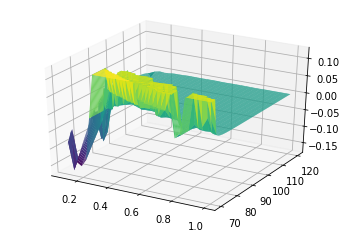

In [142]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# ax.plot_surface(x, y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none');

ax.plot_surface(x, y, Z - Zf, rstride=1, cstride=1,cmap='viridis', edgecolor='none');





In [2]:


# all inputs must be scalar

def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in the Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option, expressed in years (e.g. 0.25 for 3-month and 2 for 2 years)
    S: scalar or array_like
        The current price of the underlying asset.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    r: scalar or array_like
        The annualized risk-free interest rate, continuously compounded.
    q: scalar or array_like
        The annualized continuous dividend yield.
    callput: str
        Must be either 'call' or 'put'.

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    v = np.sqrt(vol**2*T)
    d1 = np.log(F/K)/v + 0.5*v
    d2 = d1 - v
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = opttype*(F*norm.cdf(opttype*d1)-K*norm.cdf(opttype*d2))*np.exp(-r*T)
    return price

bs = np.vectorize(blackscholes_price)

def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The current price of the underlying asset.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0) or (S <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    try:
        opttype = {'call':1, 'put':-1}[callput.lower()]
    except:
        raise ValueError('The value of callput must be either "call" or "put".')
    # compute the time-value of the option
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

In [94]:
IV = blackscholes_impv(y,x,100.,Z)
Zff = bs(y,x,100.,0.15)
IVf =  blackscholes_impv(y,x,100.,Zf)
IVff =  blackscholes_impv(y,x,100.,Zff)
IVf

KeyboardInterrupt: 

In [116]:
IVf =  blackscholes_impv(y,x,100.,Zf)

ValueError: operands could not be broadcast together with shapes (30,100) (30,100) () (100,30) 

In [112]:
np.linalg.norm(Zf - Zff)

79.12564058789276

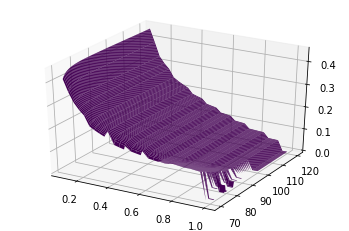

In [114]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, IVf, rstride=1, cstride=1,cmap='viridis', edgecolor='none');
# ax.plot_surface(x, y, IV, rstride=1, cstride=1,cmap='viridis', edgecolor='none');